In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("darkgrid")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


## Request HPC Resources

In [4]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
from dask.distributed import Client

log_directory="/vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs"

cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='50GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0', 
log_directory = log_directory)
print(cluster.job_script())
cluster.scale(jobs=4)

client = Client(cluster)
client

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.err
#SBATCH -o /vortexfs1/home/anthony.meza/scratch/CM4X/CM4XTransientTracers/WaterMassBudgets/logs/dask-worker-%J.out
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=47G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/bin/python -m distributed.cli.dask_worker tcp://172.16.3.58:39820 --name dummy-name --nthreads 36 --memory-limit 46.57GiB --nanny --death-timeout 60 --interface ib0



Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.58:39820,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load in data

In [5]:
ds_yearly = xr.open_mfdataset(
        datadir("model/yearly_output_0.25deg/CM4Xp125_historical_transient_tracers.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")

In [17]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/data/" + x
ds = xr.open_mfdataset(
        datadir("model/CM4Xp25_ssp585_tracers_sigma2_2020-2024.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        engine="zarr")
# ds = ds.compute()

In [18]:
z_i = np.arange(-6500, 251, 250)
z_l = (z_i[1:] + z_i[0:-1]) / 2
ds = ds.assign_coords({"z_l": z_l, "z_i":z_i})

In [19]:
ds["z"] = approximate_z_on_boundaries(ds, dim = "sigma2")
ds = ds.chunk({"sigma2_l":-1, "sigma2_i":-1, "time":1})
grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")

ds_remap = remap_vertical_coord_custom("z", ds, grid, ds["z"])

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` shoul

In [20]:
ds_loc = ds_remap.isel(xh = 100, yh = 100).compute()

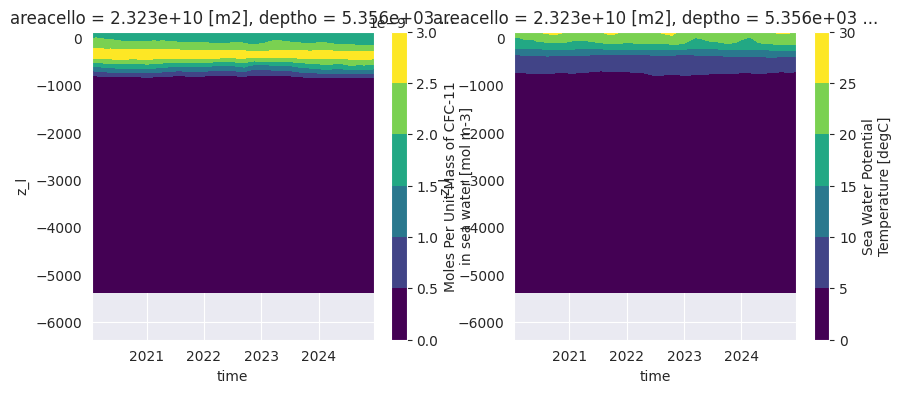

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ds_loc.cfc11.T.plot.contourf(ax = ax[0])
ds_loc.thetao.T.plot.contourf(ax = ax[1])

In [11]:
sigma2_depth = ds["thkcello"].isel(time = 0).sum("sigma2_l").compute()
z_depth = ds_remap["thkcello"].isel(time = 0).sum("z_l").compute()

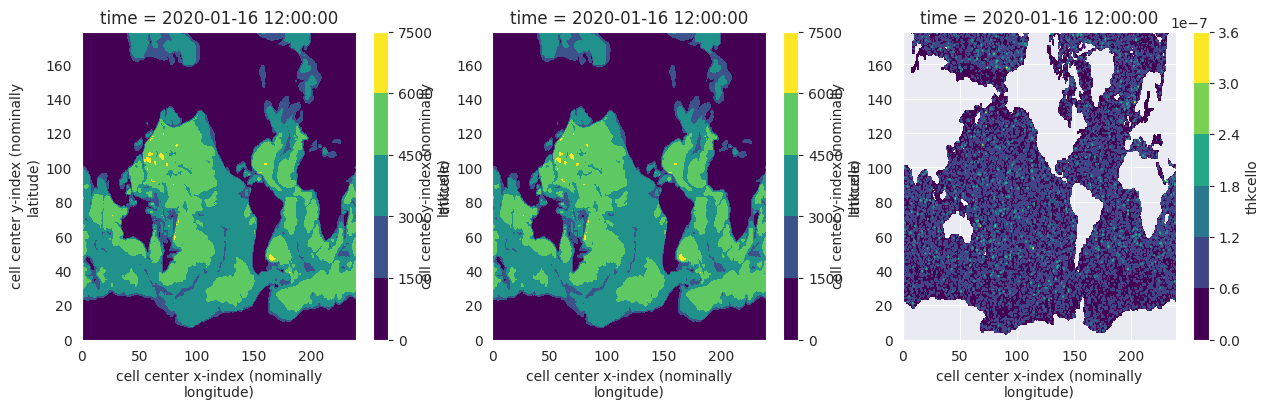

In [12]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

z_depth.plot.contourf(ax = ax[0])
sigma2_depth.plot.contourf(ax = ax[1])
(np.abs(z_depth - sigma2_depth) / z_depth).where(z_depth != 0.0).plot.contourf(ax = ax[2])

In [13]:
cfc11_mass_by_depth = grid.transform((ds["cfc11"] * ds["thkcello"]).fillna(0.), 'Z', z_i,
                                   target_data=ds["z"], method='conservative')
layer_thickness_by_depth = grid.transform(ds["thkcello"].fillna(0.), 'Z', z_i,
                                   target_data=ds["z"], method='conservative')

cfc11_by_depth = (cfc11_mass_by_depth / layer_thickness_by_depth).where(layer_thickness_by_depth != 0.0)

cfc11_by_depth_y1 = cfc11_by_depth.isel(time = -1).compute()
cfc11_by_depth_CM4Xutils_y1 = ds_remap["cfc11"].isel(time = -1).compute()

/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/vortexfs1/home/anthony.meza/miniforge3/envs/cm4x_analysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


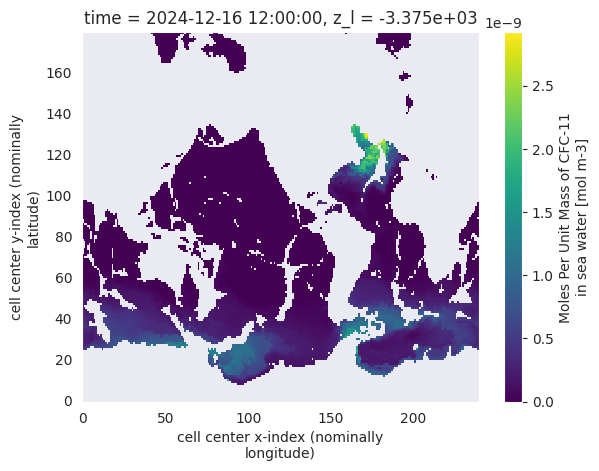

In [14]:
cfc11_by_depth_CM4Xutils_y1.isel(z_l = -15).plot()

Text(0.5, 1.0, 'Difference')

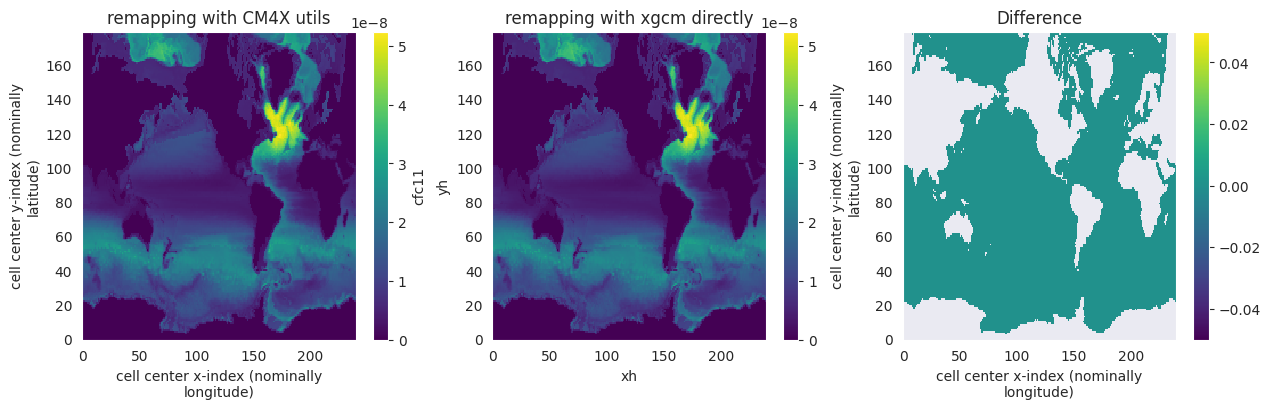

In [15]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

cfc11_by_depth_CM4Xutils_y1.sum("z_l", skipna = True).plot(ax = ax[0])
ax[0].set_title("remapping with CM4X utils")
cfc11_by_depth_y1.sum("z").plot(ax = ax[1])
ax[1].set_title("remapping with xgcm directly")

# sigma2_depth.plot.contourf(ax = ax[1])
difference = np.abs(cfc11_by_depth_CM4Xutils_y1.sum("z_l") - cfc11_by_depth_y1.sum("z"))
(difference/ cfc11_by_depth_y1.sum("z")).plot(ax = ax[2])
ax[2].set_title("Difference")


Text(0.5, 1.0, 'Difference')

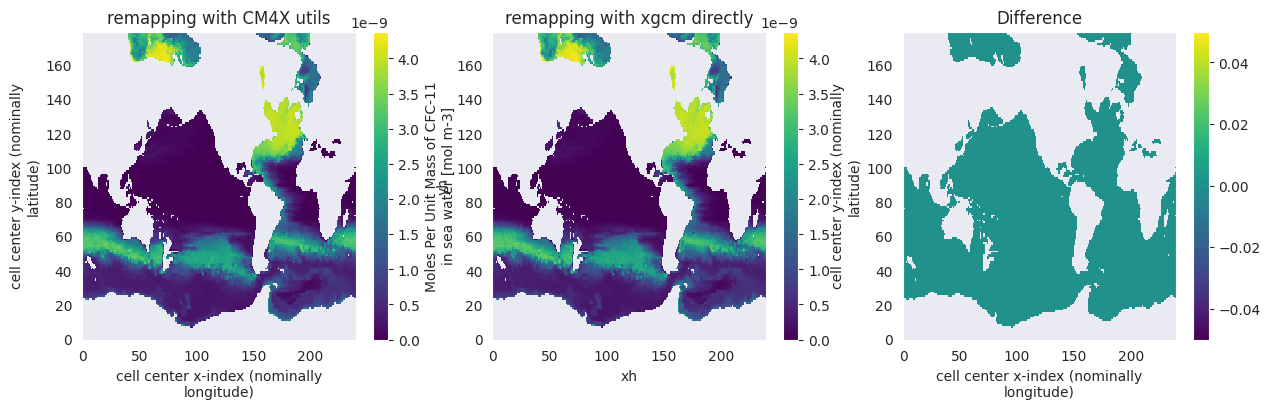

In [16]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))

z_idx = 20
cfc11_by_depth_CM4Xutils_y1.isel(z_l = z_idx).plot(ax = ax[0])
ax[0].set_title("remapping with CM4X utils")
cfc11_by_depth_y1.isel(z = z_idx).plot(ax = ax[1])
ax[1].set_title("remapping with xgcm directly")

# sigma2_depth.plot.contourf(ax = ax[1])
difference = np.abs(cfc11_by_depth_CM4Xutils_y1.isel(z_l = z_idx) - cfc11_by_depth_y1.isel(z = z_idx))
(difference/ cfc11_by_depth_y1.isel(z = z_idx)).plot(ax = ax[2])
ax[2].set_title("Difference")
